<a href="https://colab.research.google.com/github/Mccuer/Twitter-Sentiment-Analysis/blob/main/Twitter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [202]:
!pip install tensorflow_text

In [204]:
#importing necessary libraries
import numpy as np
import pandas as pd
import re
#machine learning libraries
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
#visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

In [205]:
#importing the data set
df = pd.read_csv('twitter_training.csv')
df.head()


,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [206]:
#begining data cleaning
df = df.rename(columns={'2401': 'ID', 'Borderlands': 'Topic', 'Positive': 'Sentiment', 'im getting on borderlands and i will murder you all ,': 'Content'})
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         74681 non-null  int64 
 1   Topic      74681 non-null  object
 2   Sentiment  74681 non-null  object
 3   Content    73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [207]:
#<unk> represent data that could not be processed, here we replace that with an empty string
df.dropna(subset=['Content'], inplace=True)
df['Content'] = df['Content'].str.replace('<unk>', '')
df.drop(df[df['Sentiment'] == 'Irrelevant'].index, inplace=True)
print("Sample Tweets Post Cleaning: ", df.shape[0])

Sample Tweets Post Cleaning:  61120


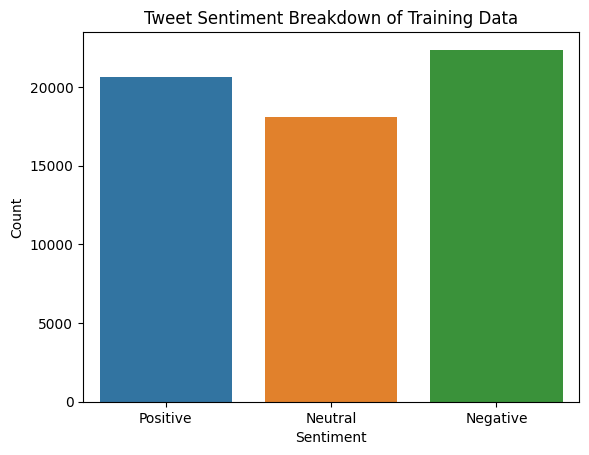

In [208]:
#visualising the makeup of the data used to train the model
sns.countplot(x="Sentiment", data=df)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title("Tweet Sentiment Breakdown of Training Data")
plt.show()

In [250]:
sentiment_counts = df.groupby(['Topic', 'Sentiment']).size().unstack(fill_value=0)

In [252]:
top_positive_topics = sentiment_counts[1].nlargest(5).index.tolist()
top_negative_topics = sentiment_counts[0].nlargest(5).index.tolist()
top_neutral_topics = sentiment_counts[-1].nlargest(5).index.tolist()

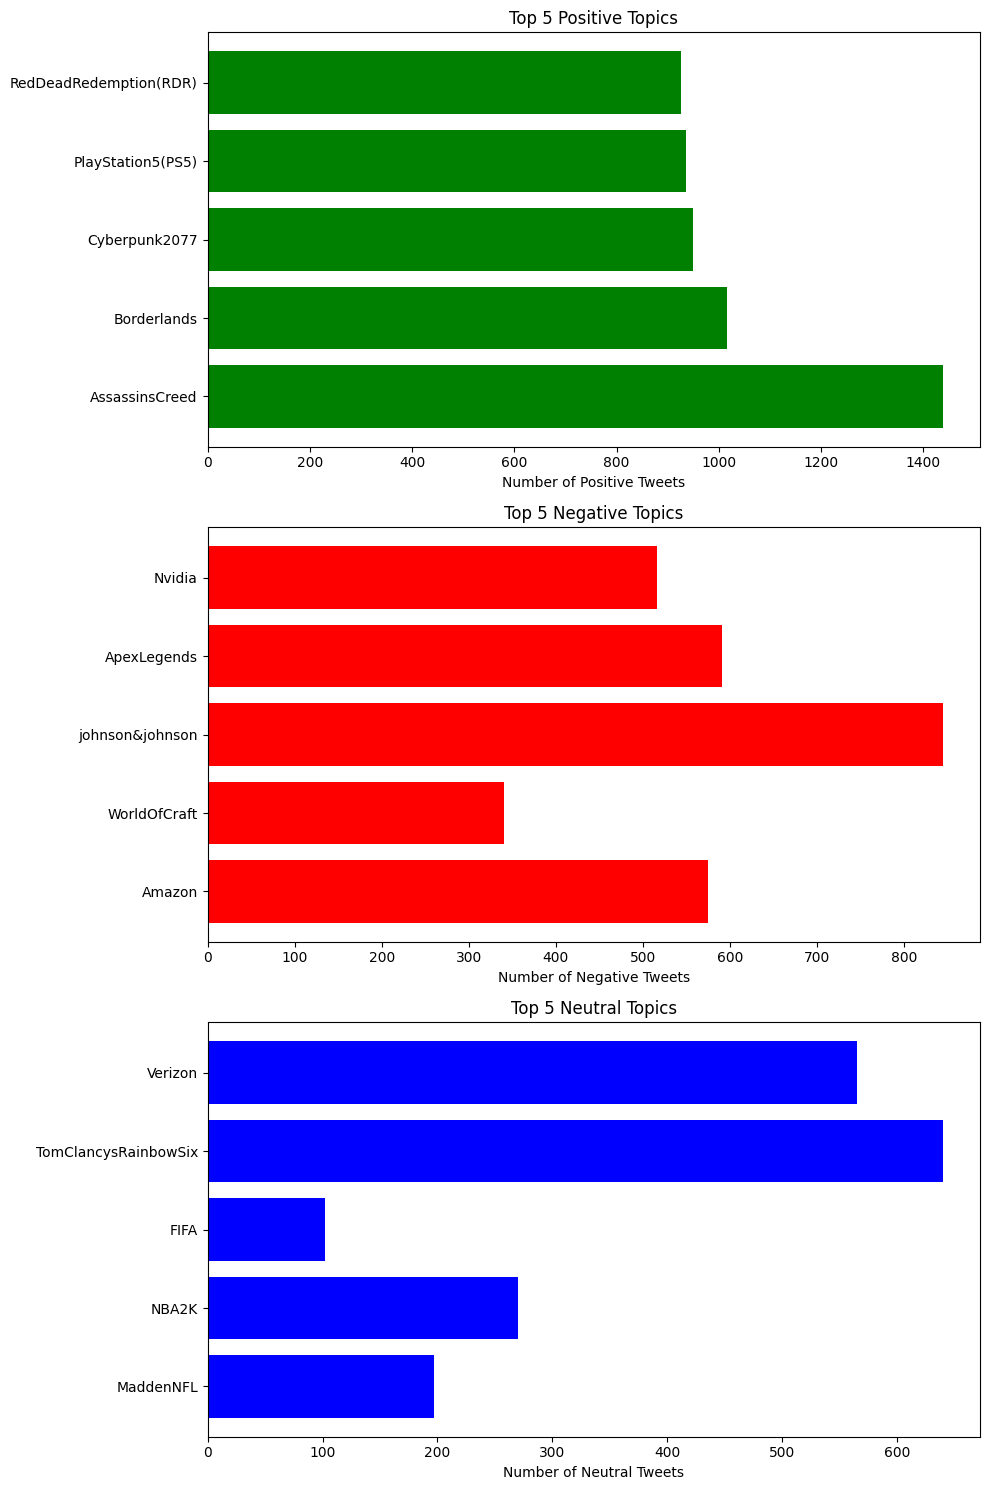

In [256]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Plot for top positive topics
axes[0].barh(top_positive_topics, sentiment_counts.loc[top_positive_topics, 1], color='green')
axes[0].set_title('Top 5 Positive Topics')
axes[0].set_xlabel('Number of Positive Tweets')

# Plot for top negative topics
axes[1].barh(top_negative_topics, sentiment_counts.loc[top_negative_topics, -1], color='red')
axes[1].set_title('Top 5 Negative Topics')
axes[1].set_xlabel('Number of Negative Tweets')

# Plot for top neutral topics
axes[2].barh(top_neutral_topics, sentiment_counts.loc[top_neutral_topics, 0], color='blue')
axes[2].set_title('Top 5 Neutral Topics')
axes[2].set_xlabel('Number of Neutral Tweets')

plt.tight_layout()
plt.show()

In [209]:
#Creating a new df with just text data
text_df=df.drop(['ID', 'Topic', 'Sentiment'], axis=1)
text_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61120 entries, 0 to 74680
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Content  61120 non-null  object
dtypes: object(1)
memory usage: 955.0+ KB


In [210]:
#changing the data to allow for data sorting
sentiment_map = {
    'Positive':1,
    'Neutral':0,
    'Negative':-1
}
df_t=df
df_t['Sentiment'] = df['Sentiment'].replace(sentiment_map)
df_t.head()

,ID,Topic,Sentiment,Content
0,2401,Borderlands,1,I am coming to the borders and I will kill you...
1,2401,Borderlands,1,im getting on borderlands and i will kill you ...
2,2401,Borderlands,1,im coming on borderlands and i will murder you...
3,2401,Borderlands,1,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,1,im getting into borderlands and i can murder y...


In [211]:
#Creating individual data frames for positive,nuetral, and negative data
df_pos = df_t[df_t['Sentiment'] == 1]
df_neg = df_t[df_t['Sentiment'] == -1]
df_ntr = df_t[df_t['Sentiment'] == 0]

df_pos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20654 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         20654 non-null  int64 
 1   Topic      20654 non-null  object
 2   Sentiment  20654 non-null  int64 
 3   Content    20654 non-null  object
dtypes: int64(2), object(2)
memory usage: 806.8+ KB


In [212]:
#determaning the amount of tweets in each subset
print("Positive Tweets: ", df_pos.shape[0])
print("Negative Tweets: ", df_neg.shape[0])
print("Nuetral Tweets: ", df_ntr.shape[0])

Positive Tweets:  20654
Negative Tweets:  22358
Nuetral Tweets:  18108


In [213]:
#ensure all sample sizes are equal
df_pos_s = df_pos.sample(1000)
df_neg_s = df_neg.sample(1000)

print("Sampled Positive Tweets: ", df_pos_s.shape[0])
print("Sampled Negative Tweets: ", df_neg_s.shape[0])

Sampled Positive Tweets:  1000
Sampled Negative Tweets:  1000
Sampled Nuetral Tweets:  1000


In [214]:
#Merge the data
training_df=pd.concat([df_pos_s,df_neg_s])

In [215]:
print(training_df.shape[0])

2000


In [216]:
print(training_df['Sentiment'].unique())

[ 1 -1]


Testing Data

In [217]:
testing_df=pd.read_csv('twitter_validation.csv')
testing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 4 columns):
 #   Column                                                                                                                                                                                                                                              Non-Null Count  Dtype 
---  ------                                                                                                                                                                                                                                              --------------  ----- 
 0   3364                                                                                                                                                                                                                                                999 non-null    int64 
 1   Facebook                                                                   

In [218]:
testing_df = testing_df.rename(columns={'3364': 'ID', 'Facebook': 'Topic', 'Irrelevant': 'Sentiment', 'I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣': 'Content'})

In [219]:
testing_df.dropna(subset=['Content'], inplace=True)
testing_df['Content'] = testing_df['Content'].str.replace('<unk>', '')
testing_df.drop(testing_df[testing_df['Sentiment'] == 'Irrelevant'].index, inplace=True)
testing_df.drop(testing_df[testing_df['Sentiment'] == 'Nuetral'].index, inplace=True)
print("Testing Tweets Post Cleaning: ", testing_df.shape[0])

Testing Tweets Post Cleaning:  828


In [220]:
testing_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 828 entries, 0 to 998
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         828 non-null    int64 
 1   Topic      828 non-null    object
 2   Sentiment  828 non-null    object
 3   Content    828 non-null    object
dtypes: int64(1), object(3)
memory usage: 32.3+ KB


In [221]:
testing_df['Sentiment'] = testing_df['Sentiment'].replace(sentiment_map)
testing_df.drop('Topic', axis=1, inplace=True)

In [222]:
training_df.head()

,ID,Topic,Sentiment,Content
52084,10547,RedDeadRedemption(RDR),1,I finally finished the original Red Dead Redem...
53272,10753,RedDeadRedemption(RDR),1,more singing concerts because im in love with ...
37056,8356,Microsoft,1,Wow...
40987,1434,Battlefield,1,We're going to play Battlefield V with an amaz...
44270,11605,Verizon,1,I'm tuning myself to


In [223]:
X_training = pd.Series(training_df['Content'])
y_training = pd.Series(training_df['Sentiment'])

X_testing = testing_df['Content']
y_testing = testing_df['Sentiment']

In [224]:
X_training_reshaped = X_training.values.reshape(-1, 1)
y_training_reshaped = y_training.values.reshape(-1, 1)

In [225]:
from sklearn.preprocessing import LabelEncoder

In [226]:
label_encoder = LabelEncoder()
X_training_encoded = label_encoder.fit_transform(X_training)

In [227]:
from keras.layers import Dense, Embedding, Flatten

In [234]:
model = Sequential()
model.add(Embedding(len(label_encoder.classes_), 10, input_length=1))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [235]:
Metric = [tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(name='precision')]

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=Metric)


In [236]:
shape = training_df.shape

# printing shape
print("Shape = {}".format(shape))

Shape = (2000, 4)


In [237]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D

for layer in model.layers:
    print(layer.output_shape)

(None, 1, 10)
(None, 10)
(None, 64)
(None, 1)


In [238]:
X_training_reshaped.shape

(2000, 1)

In [239]:
y_training.shape

(2000,)

In [249]:
model.fit(X_training_encoded, y_training, epochs=10)

Epoch 1/10
63/63 [==============================] - 0s 3ms/step - loss: -1046.3014 - accuracy: 0.4955 - precision: 1.0000
Epoch 2/10
63/63 [==============================] - 0s 3ms/step - loss: -1138.8372 - accuracy: 0.4955 - precision: 1.0000
Epoch 3/10
63/63 [==============================] - 0s 3ms/step - loss: -1236.5662 - accuracy: 0.4955 - precision: 1.0000
Epoch 4/10
63/63 [==============================] - 0s 2ms/step - loss: -1338.6653 - accuracy: 0.4955 - precision: 1.0000
Epoch 5/10
63/63 [==============================] - 0s 3ms/step - loss: -1445.4796 - accuracy: 0.4955 - precision: 1.0000
Epoch 6/10
63/63 [==============================] - 0s 4ms/step - loss: -1556.8081 - accuracy: 0.4950 - precision: 1.0000
Epoch 7/10
63/63 [==============================] - 0s 4ms/step - loss: -1673.1039 - accuracy: 0.4955 - precision: 1.0000
Epoch 8/10
63/63 [==============================] - 0s 4ms/step - loss: -1794.5282 - accuracy: 0.4955 - precision: 1.0000
Epoch 9/10
63/63 [======

In [241]:
X_testing_encoded=label_encoder.fit_transform(X_testing)

In [248]:
model.evaluate(X_testing_encoded, y_testing)

26/26 [==============================] - 0s 2ms/step - loss: 37.2816 - accuracy: 0.3225 - precision: 0.6361


[37.281585693359375, 0.3224637806415558, 0.6361031532287598]